# Capstone - Initial Models
## Author - Salinee Kingbaisomboon
### UW NetID: 1950831

Milestone 2 continues your work with the diaper manufacturing problem, using the same datasets:
1. A dataset file SECOM containing 1567 examples, each with 591 features, presented in a 1567 x 591 matrix
2. A labels file listing the classifications and date time stamp for each example

## Instructions
1. Split prepared data from Milestone 1 into training and testing
2. Build a decision tree model that detects faulty products
3. Build an ensemble model that detects faulty products
4. Build an SVM model
5. Evaluate all three models
6. Solicit specific feedback on your code

In [54]:
# Load necessary libraries
import pandas as pd
import numpy as np

from collections import Counter

from sklearn import preprocessing, tree, svm, metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE # Recursive Feature Elimination (for backward model selection)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE

from IPython.display import Image
from subprocess import check_call

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import warnings

warnings.filterwarnings("ignore") # To suppress warning

%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

# Declare Functions used in this milestone

In [2]:
# Function to replace missing numeric values
def replace_missing_value(x, col):
    # We determine the locations of NaN
    HasNan = np.isnan(x.loc[:, col]) 
    # If there are NaN
    if sum(HasNan) > 0:
        # Calculate the Median for current column without Nan
        Median = np.nanmedian(x.loc[:, col])
        # Replace the missing value with Median
        x.loc[HasNan, col] = Median
    return x.loc[:, col]

# Read, merge and perform data cleaning

In [3]:
# Load data and label
dataFilename = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data'
data_df = pd.read_csv(dataFilename, header=None, delim_whitespace=True)

labelFilename = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data'
label_df = pd.read_csv(labelFilename, header=None, delim_whitespace=True)

In [4]:
# Set pseudo names for input data
for col in data_df.columns:
    data_df.rename(columns = {col:'feature_'+ str(col)}, inplace = True)
    
# Set pseudo name for label data
label_df.rename(columns = {0:'HouseLineTestingResult'}, inplace = True)
label_df.rename(columns = {1:'TimeStamp'}, inplace = True)

# Since we didn't do the time series analysis, we don't need the timestamp column
# Drop the unused columns
label_df.drop(['TimeStamp'],axis=1, inplace=True)

In [5]:
# Clean input data
for col in data_df.columns:
    # Replace missing values with Median for current column without Nan
    data_df.loc[:, col] = replace_missing_value(data_df, col)

In [6]:
# Merge input and label data into one
df = pd.concat([data_df,label_df],axis=1)

In [7]:
# Normalize data frame
cols = df.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df)
df_normalized = pd.DataFrame(np_scaled, columns = cols)

## Explore Data

In [11]:
# View first 5 rows
df_normalized.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_133,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_149,feature_150,feature_151,feature_152,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_191,feature_192,feature_193,feature_194,feature_195,feature_196,feature_197,feature_198,feature_199,feature_200,feature_201,feature_202,feature_203,feature_204,feature_205,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_227,feature_228,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_336,feature_337,feature_338,feature_339,feature_340,feature_341,featu

In [12]:
print(df_normalized.shape) # Print DataFrame's size
print(df_normalized.dtypes) # Print DataFrame's data types

(1567, 591)
feature_0                 float64
feature_1                 float64
feature_2                 float64
feature_3                 float64
feature_4                 float64
feature_5                 float64
feature_6                 float64
feature_7                 float64
feature_8                 float64
feature_9                 float64
feature_10                float64
feature_11                float64
feature_12                float64
feature_13                float64
feature_14                float64
feature_15                float64
feature_16                float64
feature_17                float64
feature_18                float64
feature_19                float64
feature_20                float64
feature_21                float64
feature_22                float64
feature_23                float64
feature_24                float64
feature_25                float64
feature_26                float64
feature_27                float64
feature_28                float64
fe

In [13]:
# View Statistic Summary
df_normalized.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_133,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_149,feature_150,feature_151,feature_152,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_191,feature_192,feature_193,feature_194,feature_195,feature_196,feature_197,feature_198,feature_199,feature_200,feature_201,feature_202,feature_203,feature_204,feature_205,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_227,feature_228,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_336,feature_337,feature_338,feature_339,feature_340,feature_341,featu

## Handle Class Imbalance

In [14]:
# Extract features and target variable from data frame
targetOutcome = pd.DataFrame(df_normalized,columns=['HouseLineTestingResult'])
allInputs = pd.DataFrame(df_normalized,columns=df.columns.difference(['HouseLineTestingResult']))

In [15]:
# Modify data by handling class imbalance using SMOTE method
print('Original training targets shape {}'.format(Counter(targetOutcome.values.ravel())))
sm = SMOTE(random_state=0)
allInputs_resample, targetOutcome_resample = sm.fit_sample(allInputs, targetOutcome.values.ravel())
print('Resampled dataset shape {}'.format(Counter(targetOutcome_resample)))

Original training targets shape Counter({0.0: 1463, 1.0: 104})
Resampled dataset shape Counter({0.0: 1463, 1.0: 1463})


## Feature Selection

In [18]:
# Create linear regression model as the estimator
estimator = LinearRegression()
# From the Filter method, we select 10 features -- this number is arbitary (need to find the optimal number with further analysis)
selector = RFE(estimator, 10, step=1)
# Learn from this dataset
selector = selector.fit(allInputs, targetOutcome)
# The mask of selected features (which variables are selected)
print(selector.support_)
# Selected features are ranked 1. The variable with the highest rank is the one that is removed first
print(selector.ranking_)
# Print the name of selected features
f = selector.get_support(True) # the most important features
print('\033[1m\033[4mSeledted features from Backward Stepwise Model Selection are: \033[0m')
for f_index in f:
    print(df.columns[f_index])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False  T

In [52]:
# Create a new copy of data frame with selected features
selected_feature_names = ['feature_47','feature_60','feature_162','feature_164','feature_171','feature_196','feature_209','feature_324','feature_464','feature_466']
allInputs_feature_selected = allInputs[selected_feature_names].copy()

In [25]:
# View first 5 rows
allInputs_feature_selected.head()

,feature_47,feature_60,feature_162,feature_164,feature_171,feature_196,feature_209,feature_324,feature_464,feature_466
0,0.798994,0.533284,0.009981,0.026417,0.21645,0.009205,0.0,0.317877,0.0,0.0
1,0.780757,0.555275,0.088877,0.063291,0.37683,0.005046,0.0,0.430930,0.0,0.0
2,0.791108,0.810180,0.056955,0.064392,0.05772,0.008469,0.0,0.277554,0.0,0.0
3,0.794558,0.747554,0.081473,0.059439,0.05504,0.010574,0.0,0.272055,0.0,0.0
4,0.529771,0.617807,0.039136,0.022014,0.11173,0.009560,0.0,0.420716,0.0,0.0


In [47]:
# Split test(90%) and train (10%) data
X, XX, Y, YY = train_test_split(allInputs_feature_selected, targetOutcome, test_size = 0.1, random_state = 0)

# Tuning the Depth of a Tree

## 1. Dicision Tree (Gini Coefficient)

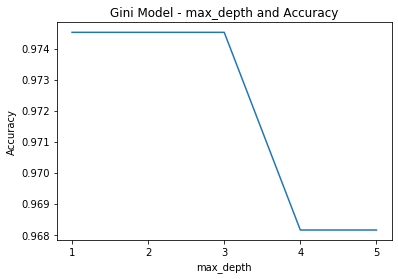

In [37]:
# List of values to try for max_depth:
max_depth_range = list(range(1, 6))# List to store the average RMSE for each value of max_depth:

# List of values to try for max_depth:
accuracy_gini = []
for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth = depth, random_state = 0)
    clf.fit(X, Y)    
    score = clf.score(XX, YY)
    accuracy_gini.append(score)
    
# Plot max_depth and accuracy for Gini model
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('max_depth')
ax.set_ylabel('Accuracy')
ax.set_title('Gini Model - max_depth and Accuracy')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(max_depth_range, accuracy_gini)
plt.show()

## 2. Random Forest (Ensemble Model)

In [38]:
# Hyperparameters
nTrees = 100 # trim number of trees
min_node_size = 5 # minimum on those size
verbose = 0

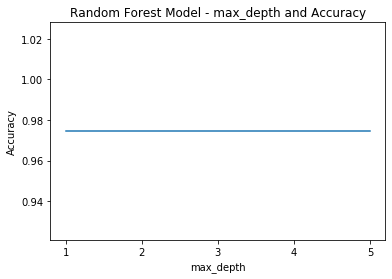

In [39]:
accuracy_random_forest = []
for depth in max_depth_range:
    clf = RandomForestClassifier(n_estimators=nTrees, max_depth=depth, random_state=0, verbose=verbose, min_samples_leaf=min_node_size)
    clf.fit(X, Y)    
    score = clf.score(XX, YY)
    accuracy_random_forest.append(score)
    
# Plot max_depth and accuracy for Rendom Forest model
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('max_depth')
ax.set_ylabel('Accuracy')
ax.set_title('Random Forest Model - max_depth and Accuracy')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(max_depth_range, accuracy_random_forest)
plt.show()

# Create Decision Trees Model

## 1. Dicision Tree (Gini Coefficient)

In [48]:
# Use information gain (default)
# Based on the tuning the depth of a tree for Gini, the best max_depth is 3
model_gini = DecisionTreeClassifier(max_depth = 3).fit(X, Y)
y_gini_predict = model_gini.predict(XX)

## 2. Random Forest (Ensemble Model)

In [49]:
# Based on the tuning the depth of a tree for Random Forest, any number of max_depth yield the same accuracy. I will do 3
model_random_forest = RandomForestClassifier(n_estimators=nTrees, max_depth=3, random_state=0, verbose=verbose, min_samples_leaf=min_node_size).fit(X, Y)
y_random_forest_predict = model_random_forest.predict(XX)

# Visualize Decision Trees Model

## 1. Dicision Tree (Gini Coefficient)

In [50]:
# Confusion Metrix
pd.DataFrame(
    metrics.confusion_matrix(YY, y_gini_predict),
    columns=['Predicted HouseLineTestingResult-pass', 'Predicted HouseLineTestingResult-fail'],
    index=['True HouseLineTestingResult-pass', 'True HouseLineTestingResult-fail']
)

,Predicted HouseLineTestingResult-pass,Predicted HouseLineTestingResult-fail
True HouseLineTestingResult-pass,152,1
True HouseLineTestingResult-fail,4,0


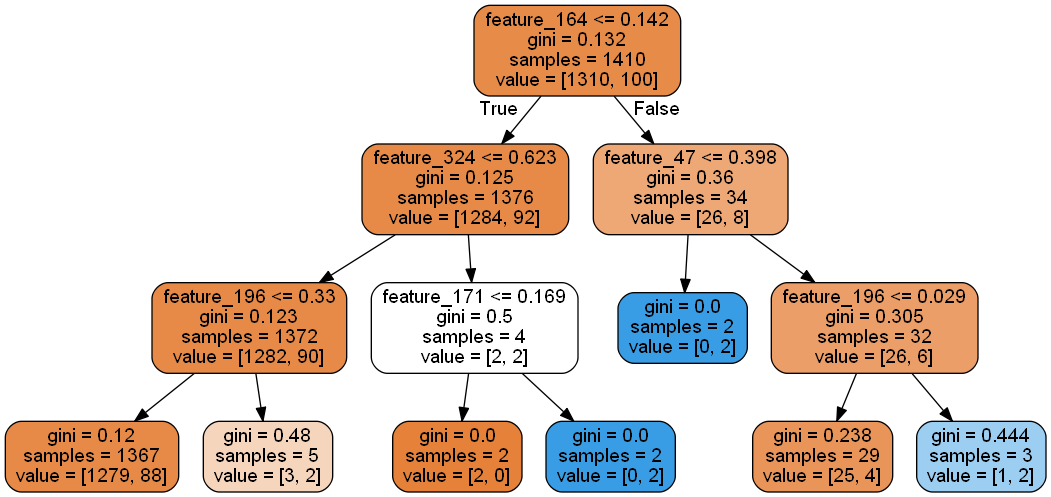

In [55]:
gini_dotfile = open("milestone_gini_dtree.dot", 'w')
tree.export_graphviz(model_gini, out_file = gini_dotfile, filled=True, rounded=True, feature_names = selected_feature_names)
gini_dotfile.close()

# Convert the dot file to a png
check_call(['dot','-Tpng','milestone_gini_dtree.dot','-o','milestone_gini_dtree.png'])

# show the png
Image(filename='milestone_gini_dtree.png', width=750, height=750)

## 2. Random Forest (Ensemble Model)

In [56]:
# Confusion Metrix
pd.DataFrame(
    metrics.confusion_matrix(YY, y_random_forest_predict),
    columns=['Predicted HouseLineTestingResult-pass', 'Predicted HouseLineTestingResult-fail'],
    index=['True HouseLineTestingResult-pass', 'True HouseLineTestingResult-fail']
)

,Predicted HouseLineTestingResult-pass,Predicted HouseLineTestingResult-fail
True HouseLineTestingResult-pass,153,0
True HouseLineTestingResult-fail,4,0


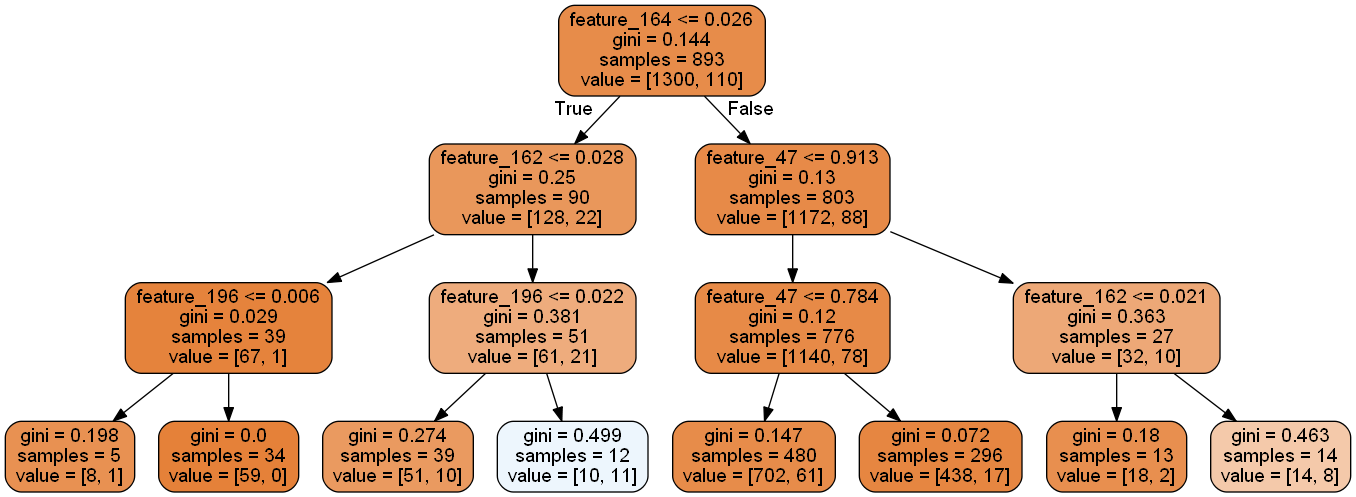

In [57]:
# Get the final Random Forest Decision Tree
last_index = len(model_random_forest.estimators_) - 1

random_forest_dotfile = open("milestone_random_forest_dtree.dot", 'w')
tree.export_graphviz(model_random_forest.estimators_[last_index], out_file = random_forest_dotfile, filled=True, rounded=True, feature_names = selected_feature_names)
random_forest_dotfile.close()

# Convert the dot file to a png
check_call(['dot','-Tpng','milestone_random_forest_dtree.dot','-o','milestone_random_forest_dtree.png'])

# show the png
Image(filename='milestone_random_forest_dtree.png', width=750, height=750)

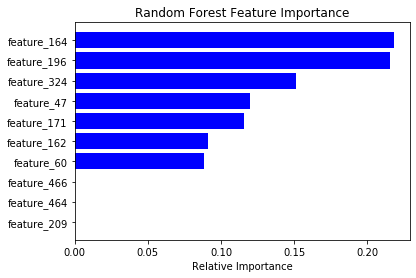

In [60]:
# Calculate feature importances
random_forest_importances = model_random_forest.feature_importances_

# Sort feature importances in descending order
random_forest_indices = np.argsort(random_forest_importances)

# Rearrange feature names so they match the sorted feature importances
random_forest_names = [selected_feature_names[i] for i in random_forest_indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Random Forest Feature Importance")

# Add bars
plt.barh(range(len(random_forest_indices)), random_forest_importances[random_forest_indices], color='b', align='center')

# Add feature names as x-axis labels
plt.yticks(range(len(random_forest_indices)), [selected_feature_names[i] for i in random_forest_indices])
plt.xlabel('Relative Importance')

# Show plot
plt.show()

# Create SVC (SVM Model)

In [61]:
# Using sklearn.model_selection.SearchGridCV to find the best settings
parameters = {'kernel':['linear', 'rbf', 'sigmoid'], 'C':[0.1, 0.9, 100], 'gamma': [0.1, 1, 5]}
svc = svm.SVC()
gsc = GridSearchCV(svc, parameters)

grid_result = gsc.fit(X, Y)
best_params = grid_result.best_params_

In [62]:
# Best hyperparameters
best_params

{'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}

In [64]:
# Set the best Hyperparameters & SVM Model

# Based on the GridSearchCV
cost = best_params['C']
gamma = best_params['gamma']
kernel = best_params['kernel']

clf = svm.SVC(gamma=gamma, kernel=kernel, C=cost).fit(X, Y)
y_predicted = clf.predict(XX)

# Evaluate all three models

## 1. Dicision Tree (Gini Coefficient)

Gini Accuracy is : 96.81528662420382%
Gini Precision is : 0.0%
Gini Recall is : 0.0%


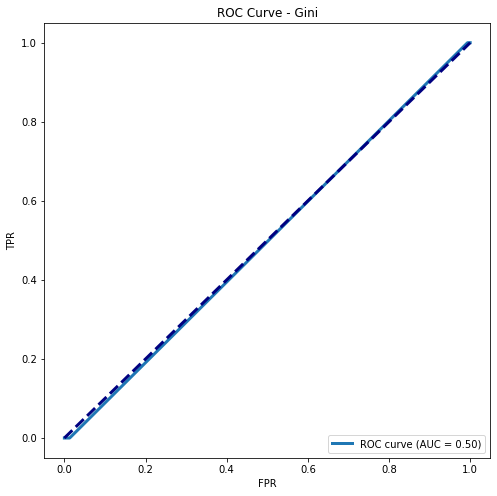

In [66]:
gini_bothProbabilities = model_gini.predict_proba(XX)
gini_probabilities = gini_bothProbabilities[:,1]

# pos_label- the label of the positive class
print("Gini Accuracy is : {}%".format(metrics.accuracy_score(YY, y_gini_predict)*100))
print("Gini Precision is : {}%".format(metrics.precision_score(YY, y_gini_predict)*100))
print("Gini Recall is : {}%".format(metrics.recall_score(YY, y_gini_predict)*100))

# False Positive Rate, True Posisive Rate, probability thresholds
fpr, tpr, th = metrics.roc_curve(YY, gini_probabilities) 
AUC = metrics.auc(fpr, tpr)

# Plot ROC Curve
plt.rcParams["figure.figsize"] = [8, 8] # Square
plt.figure()
plt.title('ROC Curve - Gini')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr, tpr, LW=3, label='ROC curve (AUC = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], color='navy', LW=3, linestyle='--') # reference line for random classifier
plt.legend(loc="lower right")
plt.show()

## 2. Random Forest (Ensemble Model)

Random Forest Accuracy is : 97.45222929936305%
Random Forest Precision is : 0.0%
Random Forest Recall is : 0.0%


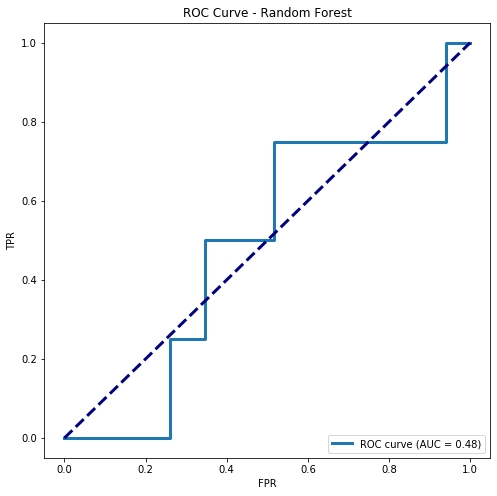

In [67]:
random_forest_bothProbabilities = model_random_forest.predict_proba(XX)
random_forest_probabilities = random_forest_bothProbabilities[:,1]

# pos_label- the label of the positive class
print("Random Forest Accuracy is : {}%".format(metrics.accuracy_score(YY, y_random_forest_predict)*100))
print("Random Forest Precision is : {}%".format(metrics.precision_score(YY, y_random_forest_predict)*100))
print("Random Forest Recall is : {}%".format(metrics.recall_score(YY, y_random_forest_predict)*100))

# False Positive Rate, True Posisive Rate, probability thresholds
fpr, tpr, th = metrics.roc_curve(YY, random_forest_probabilities) 
AUC = metrics.auc(fpr, tpr)

# Plot ROC Curve
plt.rcParams["figure.figsize"] = [8, 8] # Square
plt.figure()
plt.title('ROC Curve - Random Forest')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr, tpr, LW=3, label='ROC curve (AUC = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], color='navy', LW=3, linestyle='--') # reference line for random classifier
plt.legend(loc="lower right")
plt.show()

## 3. SVC (SVM Model)

In [65]:
print(classification_report(clf.predict(XX), YY))
print('Accuracy of the Best SVM Model on the training data is {:.2f} out of 1'.format(clf.score(X, Y)))
print('Accuracy of the Best SVM Model on the test data is {:.2f} out of 1'.format(clf.score(XX, YY)))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99       157
         1.0       0.00      0.00      0.00         0

    accuracy                           0.97       157
   macro avg       0.50      0.49      0.49       157
weighted avg       1.00      0.97      0.99       157

Accuracy of the Best SVM Model on the training data is 0.93 out of 1
Accuracy of the Best SVM Model on the test data is 0.97 out of 1


***
**Summary:**
1. Both **Decision Tree (Gini Coefficient)** and **Random Forest (Ensemble Model)** yeild not so good **AUC** (0.5 and 0.48 respectively). This indicate that the decision tree models are not the good choice for analysis.
2. On the other hand, **SVC (SVM Model)** yeild much better result. (**Accuracy** around 97% on test data).
3. The reason while **SVM** yield much better result than **Decision Trees** might due to the fact that there are so many attributes on the original data set and decision trees not working very well on the too complex type of model (tend to overfitted).
***

***
**Solicit Feedback:**  

- I decide to do **Normalization** since **SVM** not scale invariant. I'm not sure if **scaled data** will degrade the **decision trees** models.
- In this milestone, it just happend that **Decision Tree** perform better than **Random Forest**. Based on the Lesson 6, usually Random Forest perform better than Decision Trees most of the time. I'm not sure if I did something wrong during data preparation or it just end up like that for this data set.
***